<a href="https://colab.research.google.com/github/SantiagoAlvarezb/Thesis/blob/main/Thesis_Trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Special Teams Evaluation - Thesis


In [ ]:
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.8/171.8 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.6 MB/s eta 0:00:00
  Using cached libtorrent-2.0.7-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=a85b5a6cb34c40793880f8a5cad8c0d4e5c8d8dd175382b9266054910c6bc810


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Loading the data 

First, lets import all the necessary libraries and modules that'll help the development of the solution. We also indicate each of their funcionalities. 

In [ ]:
#For visualization and data manipulation  
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from matplotlib.animation import FuncAnimation
from IPython import display
import os 
import random

# Reinforcement Learning
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy 
import heapq

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### Pitch and Play Animations

We begin by sketching out the pitch. We use the dimensions given in the NFL 2022 Big Data Bowl site in Kaggle to make the visualization as accurate as possible. Therefore we use 120 for the x axis and 53.3 for the y axis. 

In [ ]:
def generate_nfl_field():
  #Functionality: generates nfl pitch with accurate dimensions
  #Input: N.A.
  #Output: fig, ax corresponding to an NFL pitch 
    
  #General figure settings
  fig=plt.figure()
  ax=fig.add_subplot(1,1,1)
  fig.set_size_inches(18.5, 10.5)

  #Pitch outline with respect to dimensions given in Kaggle 
  plt.plot([0,0],[0,53.3], color="#50AD80",linewidth=2)
  plt.plot([0,120],[53.3,53.3], color="#50AD80",linewidth=2)
  plt.plot([120,120],[53.3,0], color="#50AD80",linewidth=2)
  plt.plot([120,0],[0,0], color="#50AD80",linewidth=2)

  #Vertical yard lines
  for yard in [10,20,30,40,50,60,70,80,90,100,110]:
      plt.vlines(x=yard, ymin=0, ymax=53.3, color='#202924',linewidth=1)

  #Vertical yard line numbers     
  for x in range(20,110,10):
      num=x
      if x>50:
          num = 120-x
      ax.text(x,5,str(num-10), horizontalalignment='center', fontsize=20, color='white', fontdict={'family': 'serif'})
      ax.text(x-0.35,48.3,str(num-10),horizontalalignment='center',fontsize=20,color='white', rotation = 180, fontdict={'family': 'serif'})

  #Sideline and middle hashmarks 
  for x in range(11,110):
      ax.plot([x,x],[0,0.7], color='#50AD80',linewidth=1)
      ax.plot([x,x],[53.3,52.6], color='#50AD80',linewidth=1)
      ax.plot([x,x],[23.3,24.3], color='#50AD80',linewidth=1)
      ax.plot([x,x],[29,30], color='#50AD80',linewidth=1)
  ax.plot([12,12],[26.3,27], color='white',linewidth=1)
  ax.plot([108,108],[26.3,27], color='white',linewidth=1)


  #Pitch color shading the pitch 
  ax.axvspan(xmin=10, xmax=20, ymin=0.049, ymax=0.955, alpha=0.9, color='#2c3530')
  ax.axvspan(xmin=30, xmax=40, ymin=0.049, ymax=0.955, alpha=0.9, color='#2c3530')
  ax.axvspan(xmin=50, xmax=60, ymin=0.049, ymax=0.955, alpha=0.9, color='#2c3530')
  ax.axvspan(xmin=70, xmax=80, ymin=0.049, ymax=0.955, alpha=0.9, color='#2c3530')
  ax.axvspan(xmin=90, xmax=100, ymin=0.049, ymax=0.955, alpha=0.9, color='#2c3530')
  ax.axvspan(xmin=110, xmax=120, ymin=0.049, ymax=0.955, color='#252e29')

  ax.axvspan(xmin=0, xmax=10, ymin=0.049, ymax=0.955, color='#252e29')
  ax.axvspan(xmin=20, xmax=30, ymin=0.049, ymax=0.955, alpha=0.9, color='#252e29')
  ax.axvspan(xmin=40, xmax=50, ymin=0.049, ymax=0.955, alpha=0.9, color='#252e29')
  ax.axvspan(xmin=60, xmax=70, ymin=0.049, ymax=0.955, alpha=0.9, color='#252e29')
  ax.axvspan(xmin=80, xmax=90, ymin=0.049, ymax=0.955, alpha=0.9, color='#252e29')
  ax.axvspan(xmin=100, xmax=110, ymin=0.049, ymax=0.955, alpha=0.9, color='#252e29')

  plt.axis('off')
  return fig, ax

Lets take a look at our pitch

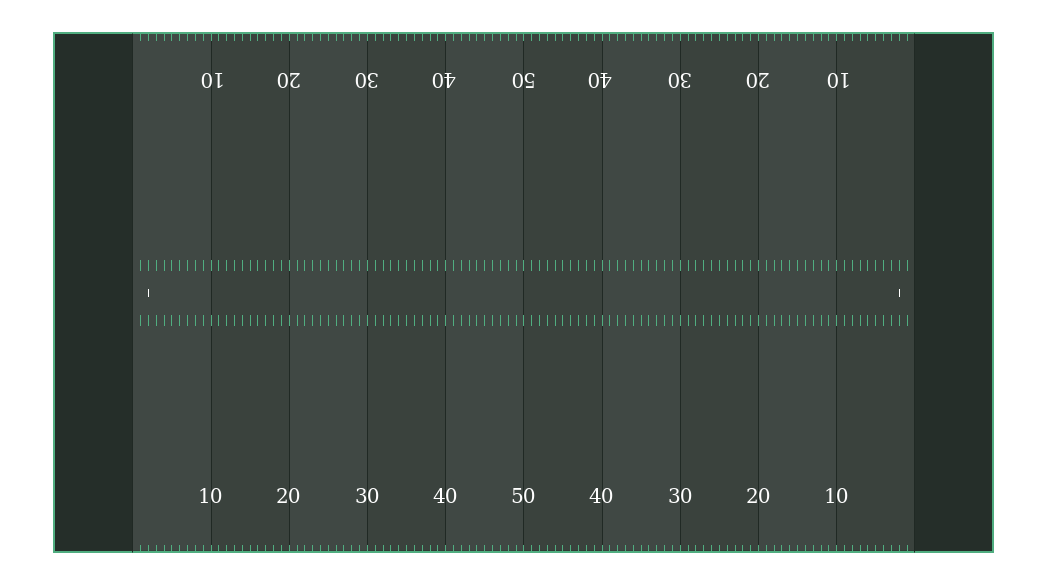

In [ ]:
generate_nfl_field()
plt.show()

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### First Approach in Reinforcement Learning

In the following section we are going to create a custom environment using tools derived from `Gym`, an open source library for developing and comparing reinforcement learning algorithms

Right now, our environment is an american football pitch with a single agent, that represents the punt/kick returner. The agents is attacking from right to left, therefore his objective is to reach the left endzone. While trying to reach his goal, the agent will need to avoid opposing players (they are static for now), avoid going out of bounds and scoring a safety (player goes into his own endzone, in this case the right endzone)



Here are some important aspects to keep in mind while designing the custom environment:

- States: Position of the player
- Actions:
  1. Move Forward 
  2. Move Backwards 
  3. Move Left 
  4. Move Right 
  5. Move Forwards and right 
  6. Move Forwards and left 
  7. Move Backwards and right
  8. Move Backwards and left
- Reward: 
  - +4: Awarded if the player scores a touchdown. 
  - +1: Actions taken which lead to the endzone. Thus if the player decides to go forward, forwards right or forwards left.
  - 0: Otherwise. Thus if the player moves left or right 
  - -1: Actions taken that go the opposite way of the endzone. Thus if the player decides to go backwards, backwards right or backwards left 
  - -2: Awarded if the player runs into an opponent 
  - -3: Awarded if the player steps out of bounds
  - -4: Awarded if the player sores a safety.

**<font color = "red"> Important: </font>** To avoid the opponents, the centroid of the regular polygon composed of the N closests opponents was found in order to calculate the distance between it and the returner. We do this to penalize the player if it is too far off from the centroid (point which represents the center of mass of the polygon and where the player should aim to go through) and reward if its close to it.
We define a threshold with value of 1 yard. Meaning that if player is more than 1 yard away from the centroid then it recieves a negative reward and a positive one if its within the threshold.




By default, we have the following values for certain variables. Unless the environment is initiated with different values, these will be used:
- `start_position`: Middle of the field, therefore at point (80, 26.65)
- `time`: 100 seconds
- `yards_step`: every second, the player moves 5 yards 
- `num_of_opponents`: 5 opponents at random positions
- `N` = closest N oponents to the agent. This is calculated with euclidean distance 

Now lets create our environment class

In [ ]:
# This is going to be for the returner!
class CustomEnvironment(gym.Env):
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __init__(self, start_position, time, yards_step, num_of_opponents, N_nearest):
    super(CustomEnvironment,self).__init__()
    self.time = time
    self.yards_step = yards_step
    self.N_nearest = N_nearest
    if start_position is None:
      start_position = np.array([80,26.65])
    self.start_position = start_position

    # Dictionary with possible actions and action space as well as observation space 
    self.action_dictionary = {0: "Forward", 1: "Backwards", 2: "Left", 3: "Right", 4: "Forward Left", 5: "Forward Right", 6: "Backwards Left", 7: "Backwards Right"}
    self.action_space = gym.spaces.Discrete(8)
    self.observation_space = gym.spaces.Box(low = np.array([0,0]), high = np.array([120,53.3]), dtype=np.float64) 
    
    # Initial position 
    self.position = np.array(self.start_position)

    # Length of the play
    self.play_length = time

    # Total reward
    self.total_reward = 0

    # Closest n opponents to returner per frame  
    self.closest_n_opp_per_frame = []

    #Opponents
    self.start_opponent_positions = []
    for i in range(num_of_opponents):
      self.start_opponent_positions.append(np.array([random.randint(10,60),random.randint(7,47)]))
      # self.opponent_positions.append(np.array([random.randint(20,40),random.randint(30,40)]))

    self.opponent_positions = self.start_opponent_positions

    # Centroid list
    self.centroid = []
    self.threshold = 1

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def step(self, action): #Change action for action_n which is a list of actions, one for each agent
    done = False #Here we we would need a list of size n (number of opponents) that is filled with False
    info = {} #Ditto a list with {} in it n times
    reward = 0 # and same for reward... and they abviously start with zero

    #-------------------------------------------------------------------------------
    # Reduces the play length by 1 second 
    self.play_length -= 1

    # Take into account boundaries of the field
    self.position = np.array([np.clip(self.position[0],0,120), np.clip(self.position[1],0,53.3)])

    #-------------------------------------------------------------------------------
    # Distances between opponents and returner
    distances = []
    dictionary = {}

    def get_key(val):
      for key, value in dictionary.items():
          if (val == value) and (key not in self.closest_opp_index):
            return key

    for i in range(1):
      for j in range(i, len(self.opponent_positions)):
        distance = ((self.position[0] - self.opponent_positions[j][0])**2 + (self.position[1] - self.opponent_positions[j][1])**2)**0.5
        distances.append(distance)
        dictionary[j] = distance

      n_shortest = heapq.nsmallest(self.N_nearest, distances)

      self.closest_opp_index=[]
      for i in n_shortest:
        self.closest_opp_index.append(get_key(i))

      positions = []
      for i in self.closest_opp_index:
        self.closest_opp_index_coordinates = []
        positions.append(self.opponent_positions[i])
        self.closest_opp_index_coordinates.append(self.opponent_positions[i][0])
        self.closest_opp_index_coordinates.append(self.opponent_positions[i][1])
        self.closest_n_opp_per_frame.append(self.closest_opp_index_coordinates)

    # Opponent random movement 
    short_term_memory = []
    for count, value in enumerate(self.opponent_positions):
      num1 = random.randint(-1, 1)
      num2 = random.randint(-1, 1)
      if state[count] == 0:
        new_value = value + (0,num1)
        state[count] = 1
      elif state[count] == 1: 
        new_value = value + (0,-(num1))
        state[count] = 2
      elif state[count] == 2: 
        new_value = value + (num2,0)
        state[count] = 3
      elif state[count] == 3: 
        new_value = value + (-(num2),0)
        state[count] = 0

      short_term_memory.append(new_value)
      memory.append(new_value)
    self.opponent_positions = short_term_memory

    #-------------------------------------------------------------------------------
    # Centroids
    def Centroid(list_of_points):
      x_cord = sum(list(zip(*list_of_points))[0])
      y_cord = sum(list(zip(*list_of_points))[1])
      centroid = (x_cord/len(list_of_points),y_cord/len(list_of_points))
      return centroid

    self.centroid.append(Centroid(positions))
    distance_centroid = ((self.position[0] - Centroid(positions)[0])**2 + (self.position[1] - Centroid(positions)[1])**2)**0.5

    #-------------------------------------------------------------------------------
    # Movement (x,y) (Assuming we score the touchdown to the left), rewards

    #Forward
    if action == 0:
      self.position -= (self.yards_step,0)
      self.total_reward += 1
      reward = 1
      if distance_centroid > self.threshold:
        self.total_reward -= 0.5
        reward = 0.5
      else:
        pass

    # Backwards
    elif action == 1:
      self.position += (self.yards_step,0)
      self.total_reward -= 1
      reward = -1
    
    # Left
    elif action == 2:
      self.position -= (0,self.yards_step)
      self.total_reward += 0
      reward = 0
   
    # Right    
    elif action == 3:
      self.position += (0,self.yards_step)
      self.total_reward += 0
      reward = 0

    # Forwards Left
    elif action == 4:
      self.position -= (self.yards_step,self.yards_step)
      self.total_reward += 1
      reward = 1
      if distance_centroid > self.threshold:
        self.total_reward -= 0.5
        reward = 0.5
      else:
        pass

    # Forwards Right
    elif action == 5:
      self.position += (-(self.yards_step),self.yards_step)
      self.total_reward += 1
      reward = 1
      if distance_centroid > self.threshold:
        self.total_reward -= 0.5
        reward = 0.5
      else:
        pass

    # Backwards Left
    elif action == 6:
      self.position += (self.yards_step,-(self.yards_step))
      self.total_reward -= 1
      reward = -1

    # Backwards Right
    elif action == 7:
      self.position += (self.yards_step,self.yards_step)
      self.total_reward -= 1
      reward = -1

    # Rewards taking into account out of bounds and TDs 
    # Touchdown 
    if self.position[0] <= 10:
      self.total_reward += 4
      reward = 4

    # Safety
    elif self.position[0] >= 110:
      self.total_reward -= 4
      reward = -4

    #Out of Bounds
    elif self.position[1] <= 0:
      self.total_reward -= 3
      reward = -3 
    elif self.position[1] >= 53.3:
      self.total_reward -= 3
      reward = -3 

    # Hit an obstacle
    elif any((i == self.position).all() for i in self.opponent_positions):
      self.total_reward -= 2
      reward = -2
    
    #-------------------------------------------------------------------------------
    # Stopping criteria

    # Time expires
    if self.play_length == 0:
      done = True
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
      return self.position, reward, done, info 

    # Went out of bounds 
    elif (self.position[1] <= 0):
      done = True 
      self.position[1] = 0
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
      return self.position, reward, done, info 
    
    # Went out of bounds
    elif (self.position[1] >= 53.3):
      done = True 
      self.position[1] = 53.3
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Did we reach the end zone 
    elif (self.position[0] <= 10):
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Did we reach our own endzone
    elif (self.position[0] >= 110):
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Did we hit an opponent
    elif any((i == self.position).all() for i in self.opponent_positions):
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    return self.position, reward, done, info 
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  
  def add_positions(self):
    positions.append(self.position)
    for i in self.opponent_positions:
      blocker_position.append(i)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def animation(self, episode_list, mode='console'):
    #-------------------------------------------------------------------------------
    # Creating returner df
    column_values = ['x', 'y']
    returner_df = pd.DataFrame(data = episode_list[0], columns = column_values)
    returner_df['frames'] = returner_df.index

    #-------------------------------------------------------------------------------
    # Creating blocker df
    frame_num = []
    k=0
    for i in range(1,len(blocker_episode_list[0])+1):
      frame_num.append(k)
      if i % len(self.opponent_positions) == 0:
        k += 1
    blocker_df = pd.DataFrame(data = blocker_episode_list[0], columns = column_values)
    blocker_df['frames'] = frame_num

    # print("This is blocker_df", blocker_df)

    #-------------------------------------------------------------------------------
    # Creating distance df
    frame_num_dist = []
    k_dist=0
    for i in range(1,len(self.closest_n_opp_per_frame)+1):
      frame_num_dist.append(k_dist)
      if i % self.N_nearest == 0:
        k_dist += 1
    distance_df = pd.DataFrame(data=self.closest_n_opp_per_frame, columns = column_values)
    distance_df['frames'] = frame_num_dist

    # print("This is frame_num_dist", distance_df)

    #-------------------------------------------------------------------------------
    # Creating centroid df
    centroid_df = pd.DataFrame(data = self.centroid, columns = column_values)
    centroid_df['frames'] = centroid_df.index

    #-------------------------------------------------------------------------------
    #set NFL pitch 
    fig, ax = generate_nfl_field()

    #set color of plot points to differentiate between home team, away team and football 
    marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
    returner, = ax.plot([], [], ms=12, markerfacecolor='#E01E38',**marker_kwargs)
    blocker, = ax.plot([], [], ms=12, markerfacecolor='#A209A5',**marker_kwargs)
    centroid, = ax.plot([], [], ms=10, markerfacecolor='#F7A41A',**marker_kwargs)
    distance, = plt.plot([], [], '#EC4B27', animated=True)

    #-------------------------------------------------------------------------------
    #update formula used in animation
    def visualize_play(frame):
      connections = []

      player = returner_df[returner_df["frames"] == frame]
      p1 = player.iloc[0, [0,1]].values.flatten().tolist()
      connections.append(p1)
      obstacle = blocker_df[blocker_df["frames"] == frame]
      center = centroid_df[centroid_df["frames"] == frame]
      distances = distance_df[distance_df["frames"] == frame]
      for i in range(self.N_nearest):
        p2 = distances.iloc[i, [0,1]].values.flatten().tolist()
        connections.append(p2)
        connections.append(p1)
      links = list(zip(*connections))
      x = links[0]
      y = links[1]

      returner.set_data(player['x'], player['y'])
      blocker.set_data(obstacle['x'], obstacle['y'])
      centroid.set_data(center['x'], center['y'])
      distance.set_data(x, y)

    #With positional data of players and football for every frame, we animate 
    animation = FuncAnimation(fig, visualize_play, frames=len(returner_df), interval=100)
    video =animation.to_html5_video() 
    html = display.HTML(video) 
    display.display(html)
    plt.close()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def reset(self):
    self.position = np.array(self.start_position)
    self.opponent_positions = self.start_opponent_positions
    self.total_reward = 0
    self.play_length = self.time
    self.closest_n_opp_per_frame = []
    self.centroid = []
    # self.opponent_positions = []
    return self.position

Now that we have created our custom environment class, lets initialize it

In [ ]:
# Initialize with default settings
start_position = None 
time = 100
yards_step = 1
num_of_opponents = 22
N_nearest = 3
env = CustomEnvironment(start_position = start_position, time=time, yards_step=yards_step, num_of_opponents = num_of_opponents, N_nearest = N_nearest)

Lets look at a random observation and a random action 

In [ ]:
print("A random observation:", env.observation_space.sample())
print("A random action:", env.action_space.sample())

A random observation: [78.05659967 14.64139716]
A random action: 6


Now, we are going to test our model with random actions. For each episode we will see the associated score as well as an animation of the path taken by the agent

In [ ]:
episodes = 1
episode_list = []
blocker_episode_list = []
for episode in range(1, episodes+1):
  obs = env.reset()
  done = False
  score = 0
  positions = []
  blocker_position = []
  memory = []
  test = []

  state = [0] * num_of_opponents
  while not done:   
    env.add_positions()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    score += reward 
  positions.pop()
  print("Episode:{} Score:{}".format(episode,score))
  # print("Memory archive:", memory)
  episode_list.append(positions)
  # print("This is blocker_position:", blocker_position)
  for i in range(num_of_opponents):
    test.append(blocker_position[i])
  test = test + memory
  # print("This is test", test )
  blocker_episode_list.append(test)
  env.animation(episode_list)
  episode_list= []
  blocker_episode_list= []
env.close()

Episode:1 Score:-24.0


In [ ]:
log_path = os.path.join("Training","Logs")
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=20000, progress_bar=True)

Logging to Training/Logs/PPO_1


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -19.9    |
| time/              |          |
|    fps             | 315      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -14         |
| time/                   |             |
|    fps                  | 350         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016796675 |
|    clip_fraction        | 0.424       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.06       |
|    explained_variance   | 0.000999    |
|    learning_rate        | 0.

In [ ]:
simple_nfl_model_path = os.path.join("Training", "Saved Models", "Simple_NFL_PPO")

In [ ]:
model.save(simple_nfl_model_path)

/usr/local/lib/python3.9/dist-packages/stable_baselines3/common/save_util.py:278: UserWarning: Path 'Training/Saved Models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [ ]:
del model

In [ ]:
model = PPO.load(simple_nfl_model_path, env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
episodes = 1
episode_list = []
blocker_episode_list = []
for episode in range(1, episodes+1):
  obs = env.reset()
  done = False
  score = 0
  positions = []
  blocker_position = []
  memory = []
  test = []

  while not done:   
    env.add_positions()
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    score += reward 
  positions.pop()
  print("Episode:{} Score:{}".format(episode,score))
  episode_list.append(positions)
  for i in range(num_of_opponents):
    test.append(blocker_position[i])
  test = test + memory
  blocker_episode_list.append(blocker_position)
  env.animation(episode_list)
  episode_list= []
  blocker_episode_list= []
env.close()

Episode:1 Score:39.5


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

Now lets do this for the opponent who wants to chase down the returner

In [ ]:
# This is going to be for the returner!
class CustomEnvironment(gym.Env):
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __init__(self, start_position, time, yards_step, num_of_opponents, N_nearest):
    super(CustomEnvironment,self).__init__()
    self.time = time
    self.yards_step = yards_step
    self.N_nearest = N_nearest
    if start_position is None:
      start_position = np.array([80,26.65])
    self.start_position = start_position

    # Dictionary with possible actions and action space as well as observation space 
    self.action_dictionary = {0: "Forward", 1: "Backwards", 2: "Left", 3: "Right", 4: "Forward Left", 5: "Forward Right", 6: "Backwards Left", 7: "Backwards Right"}
    self.action_space = gym.spaces.Discrete(8)
    self.observation_space = gym.spaces.Box(low = np.array([0,0]), high = np.array([120,53.3]), dtype=np.float64) 
    
    # Initial position 
    self.position = np.array(self.start_position)

    # Length of the play
    self.play_length = time

    # Total reward
    self.total_reward = 0

    # Closest n opponents to returner per frame  
    self.closest_n_opp_per_frame = []

    #Opponents
    self.start_opponent_positions = []
    for i in range(num_of_opponents):
      self.start_opponent_positions.append(np.array([random.randint(10,60),random.randint(7,47)]))
      # self.opponent_positions.append(np.array([random.randint(20,40),random.randint(30,40)]))

    self.opponent_positions = self.start_opponent_positions

    # Centroid list
    self.centroid = []
    self.threshold = 1

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def step(self, action): #Change action for action_n which is a list of actions, one for each agent
    done = False #Here we we would need a list of size n (number of opponents) that is filled with False
    info = {} #Ditto a list with {} in it n times
    reward = 0 # and same for reward... and they abviously start with zero

    #-------------------------------------------------------------------------------
    # Reduces the play length by 1 second 
    self.play_length -= 1

    # Take into account boundaries of the field
    self.position = np.array([np.clip(self.position[0],0,120), np.clip(self.position[1],0,53.3)])

    #-------------------------------------------------------------------------------
    # Distances between opponents and returner
    distances = []
    dictionary = {}

    def get_key(val):
      for key, value in dictionary.items():
          if (val == value) and (key not in self.closest_opp_index):
            return key

    for i in range(1):
      for j in range(i, len(self.opponent_positions)):
        distance = np.sqrt(np.sum((self.position - self.opponent_positions)**2))
        distances.append(distance)
        dictionary[j] = distance

      # print("This is the distance", distances)

      n_shortest = heapq.nsmallest(self.N_nearest, distances)

      self.closest_opp_index=[]
      for i in n_shortest:
        self.closest_opp_index.append(get_key(i))

      positions = []
      for i in self.closest_opp_index:
        self.closest_opp_index_coordinates = []
        positions.append(self.opponent_positions[i])
        self.closest_opp_index_coordinates.append(self.opponent_positions[i][0])
        self.closest_opp_index_coordinates.append(self.opponent_positions[i][1])
        self.closest_n_opp_per_frame.append(self.closest_opp_index_coordinates)

    # Opponent random movement 
    short_term_memory = []
    for count, value in enumerate(self.opponent_positions):
      num1 = random.randint(-1, 1)
      num2 = random.randint(-1, 1)
      if state[count] == 0:
        new_value = value + (0,num1)
        state[count] = 1
      elif state[count] == 1: 
        new_value = value + (0,-(num1))
        state[count] = 2
      elif state[count] == 2: 
        new_value = value + (num2,0)
        state[count] = 3
      elif state[count] == 3: 
        new_value = value + (-(num2),0)
        state[count] = 0

      short_term_memory.append(new_value)
      memory.append(new_value)
    self.opponent_positions = short_term_memory

    # print("These are the distances:", distances, "between returner at position", self.position, "and opponent at position", self.opponent_positions)

    #-------------------------------------------------------------------------------
    # Centroids
    def Centroid(list_of_points):
      x_cord = sum(list(zip(*list_of_points))[0])
      y_cord = sum(list(zip(*list_of_points))[1])
      centroid = (x_cord/len(list_of_points),y_cord/len(list_of_points))
      return centroid

    self.centroid.append(Centroid(positions))
    distance_centroid = ((self.position[0] - Centroid(positions)[0])**2 + (self.position[1] - Centroid(positions)[1])**2)**0.5

    #-------------------------------------------------------------------------------
    # Movement (x,y) (Assuming we score the touchdown to the left), rewards

    #Lets check where our target is 
    # print("This is the chasers position:", self.position)
    # print("This is the target pposition:", self.opponent_positions)

    # 0: "Forward", 1: "Backwards", 2: "Left", 3: "Right", 4: "Forward Left", 5: "Forward Right", 6: "Backwards Left", 7: "Backwards Right"

    dir = -1 

    # On the same x coord
    if self.opponent_positions[0][0] == self.position[0]:
      if self.opponent_positions[0][1] < self.position[1]:
        # print("The target is to the left of us!")
        dir = 2
      if self.opponent_positions[0][1] > self.position[1]:
        # print("The target is to the right of us!")
        dir = 3

    # On the same y cood
    elif self.opponent_positions[0][1] == self.position[1]:
      if self.opponent_positions[0][0] < self.position[0]:
        # print("The target is in front of us!")
        dir = 0
      if self.opponent_positions[0][0] > self.position[0]:
        # print("The target is behind us!")
        dir = 1

    # Quadrants
    elif (self.opponent_positions[0][0] < self.position[0]) and (self.opponent_positions[0][1] > self.position[1]):
      # print("target is in the first quad")
      dir = 4
    elif (self.opponent_positions[0][0] > self.position[0]) and (self.opponent_positions[0][1] > self.position[1]):
      # print("target is in the second quad")
      dir = 7
    elif (self.opponent_positions[0][0] > self.position[0]) and (self.opponent_positions[0][1] < self.position[1]):
      # print("target is in the third quad")
      dir = 6
    elif (self.opponent_positions[0][0] < self.position[0]) and (self.opponent_positions[0][1] < self.position[1]):
      # print("target is in the fourth quad")
      dir =  5
    
    # print("------")


    #Forward
    if action == 0:
      self.position -= (self.yards_step,0)
      new_dista = np.sqrt(np.sum((self.position - self.opponent_positions)**2))
      if (new_dista < distances[0]) and (dir == 0):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Backwards
    elif action == 1:
      self.position += (self.yards_step,0)
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 1):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5
    
    # Left
    elif action == 2:
      self.position -= (0,self.yards_step)
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 2):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5
   
    # Right    
    elif action == 3:
      self.position += (0,self.yards_step)
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 3):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Forwards Left
    elif action == 4:
      self.position -= (self.yards_step,self.yards_step)
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 4):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Forwards Right
    elif action == 5:
      self.position += (-(self.yards_step),self.yards_step)
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 5):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Backwards Left
    elif action == 6:
      self.position += (self.yards_step,-(self.yards_step))
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 6):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Backwards Right
    elif action == 7:
      self.position += (self.yards_step,self.yards_step)
      new_dista = ((self.position[0] - self.opponent_positions[0][0])**2 + (self.position[1] - self.opponent_positions[0][1])**2)**0.5
      if (new_dista < distances[0]) and (dir == 7):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < distances[0]):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == distances[0]:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    #Out of Bounds
    elif self.position[1] <= 0:
      self.total_reward -= 10
      reward = -10 
    elif self.position[1] >= 53.3:
      self.total_reward -= 10
      reward = -10

    # Hit an obstacle
    elif any((i == self.position).all() for i in self.opponent_positions):
      self.total_reward += 20
      reward = 20

    elif new_dista < 5:
      self.total_reward += 20
      reward = 20

    
    #-------------------------------------------------------------------------------
    # Stopping criteria
    
    # Time expires
    if self.play_length == 0:
      print("Stop due to time")
      done = True
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
      return self.position, reward, done, info 

    # Went out of bounds 
    elif (self.position[1] <= 0):
      print("Stop cause i went out of bounds")
      done = True 
      self.position[1] = 0
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
      return self.position, reward, done, info 
    
    # Went out of bounds
    elif (self.position[1] >= 53.3):
      print("Stop cause i went out of bounds")
      done = True 
      self.position[1] = 53.3
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Did we hit an opponent
    elif any((i == self.position).all() for i in self.opponent_positions):
      print("Stop casue we hit an opponent")
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Are we relativelly close?
    elif new_dista < 4:
      print("Stop because we are relatively close")
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    return self.position, reward, done, info 
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  
  def add_positions(self):
    positions.append(self.position)
    for i in self.opponent_positions:
      blocker_position.append(i)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def animation(self, episode_list, mode='console'):
    #-------------------------------------------------------------------------------
    # Creating returner df
    column_values = ['x', 'y']
    returner_df = pd.DataFrame(data = episode_list[0], columns = column_values)
    returner_df['frames'] = returner_df.index

    #-------------------------------------------------------------------------------
    # Creating blocker df
    frame_num = []
    k=0
    for i in range(1,len(blocker_episode_list[0])+1):
      frame_num.append(k)
      if i % len(self.opponent_positions) == 0:
        k += 1
    blocker_df = pd.DataFrame(data = blocker_episode_list[0], columns = column_values)
    blocker_df['frames'] = frame_num

    # print("This is blocker_df", blocker_df)

    #-------------------------------------------------------------------------------
    # Creating distance df
    frame_num_dist = []
    k_dist=0
    for i in range(1,len(self.closest_n_opp_per_frame)+1):
      frame_num_dist.append(k_dist)
      if i % self.N_nearest == 0:
        k_dist += 1
    distance_df = pd.DataFrame(data=self.closest_n_opp_per_frame, columns = column_values)
    distance_df['frames'] = frame_num_dist

    # print("This is frame_num_dist", distance_df)

    #-------------------------------------------------------------------------------
    # Creating centroid df
    centroid_df = pd.DataFrame(data = self.centroid, columns = column_values)
    centroid_df['frames'] = centroid_df.index

    #-------------------------------------------------------------------------------
    #set NFL pitch 
    fig, ax = generate_nfl_field()

    #set color of plot points to differentiate between home team, away team and football 
    marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
    returner, = ax.plot([], [], ms=12, markerfacecolor='#E01E38',**marker_kwargs)
    blocker, = ax.plot([], [], ms=12, markerfacecolor='#A209A5',**marker_kwargs)
    centroid, = ax.plot([], [], ms=10, markerfacecolor='#F7A41A',**marker_kwargs)
    distance, = plt.plot([], [], '#EC4B27', animated=True)

    #-------------------------------------------------------------------------------
    #update formula used in animation
    def visualize_play(frame):
      connections = []

      player = returner_df[returner_df["frames"] == frame]
      p1 = player.iloc[0, [0,1]].values.flatten().tolist()
      connections.append(p1)
      obstacle = blocker_df[blocker_df["frames"] == frame]
      center = centroid_df[centroid_df["frames"] == frame]
      distances = distance_df[distance_df["frames"] == frame]
      for i in range(self.N_nearest):
        p2 = distances.iloc[i, [0,1]].values.flatten().tolist()
        connections.append(p2)
        connections.append(p1)
      links = list(zip(*connections))
      x = links[0]
      y = links[1]

      returner.set_data(player['x'], player['y'])
      blocker.set_data(obstacle['x'], obstacle['y'])
      centroid.set_data(center['x'], center['y'])
      distance.set_data(x, y)

    #With positional data of players and football for every frame, we animate 
    animation = FuncAnimation(fig, visualize_play, frames=len(returner_df), interval=100)
    video =animation.to_html5_video() 
    html = display.HTML(video) 
    display.display(html)
    plt.close()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def reset(self):
    self.position = np.array(self.start_position)
    self.opponent_positions = self.start_opponent_positions
    self.total_reward = 0
    self.play_length = self.time
    self.closest_n_opp_per_frame = []
    self.centroid = []
    # self.opponent_positions = []
    return self.position
    

In [ ]:
# Initialize with default settings
start_position = None 
time = 200
yards_step = 1
num_of_opponents = 1
N_nearest = 1
env = CustomEnvironment(start_position = start_position, time=time, yards_step=yards_step, num_of_opponents = num_of_opponents, N_nearest = N_nearest)

In [ ]:
print("A random observation:", env.observation_space.sample())
print("A random action:", env.action_space.sample())

A random observation: [90.39351811  7.47983055]
A random action: 5


In [ ]:
episodes = 1
episode_list = []
blocker_episode_list = []
for episode in range(1, episodes+1):
  obs = env.reset()
  done = False
  score = 0
  positions = []
  blocker_position = []
  memory = []
  test = []

  state = [0] * num_of_opponents
  while not done:   
    env.add_positions()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    score += reward 
  positions.pop()
  print("Episode:{} Score:{}".format(episode,score))
  # print("Memory archive:", memory)
  episode_list.append(positions)
  # print("This is blocker_position:", blocker_position)
  for i in range(num_of_opponents):
    test.append(blocker_position[i])
  test = test + memory
  # print("This is test", test )
  blocker_episode_list.append(test)
  env.animation(episode_list)
  episode_list= []
  blocker_episode_list= []
env.close()

Stop due to time
Episode:1 Score:-406


In [ ]:
log_path = os.path.join("Training","Logs")
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=50000, progress_bar=True)

Logging to Training/Logs/PPO_10


Output()

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -361     |
| time/              |          |
|    fps             | 841      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop due to time

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 190        |
|    ep_rew_mean          | -307       |
| time/                   |            |
|    fps                  | 532        |
|    iterations           | 3          |
|    time_elapsed         | 11         |
|    total_timesteps      | 6144       |
| train/                  |            |
|    approx_kl            | 0.01584905 |
|    clip_fraction        | 0.292      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.02      |
|    explained_variance   | 0.000275   |
|    learning_rate        | 0.0003     |
|    loss                 | 143        |
|    n_updates            | 20         |
|    policy_gradient_loss | -0.0298    |
|    value_loss           | 453        |
----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 173         |
|    ep_rew_mean          | -269        |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 4           |
|    time_elapsed         | 15          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012525116 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 0.00334     |
|    learning_rate        | 0.0003      |
|    loss                 | 148         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0144     |
|    value_loss           | 381         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 160         |
|    ep_rew_mean          | -238        |
| time/                   |             |
|    fps                  | 521         |
|    iterations           | 5           |
|    time_elapsed         | 19          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.013722029 |
|    clip_fraction        | 0.188       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.00619     |
|    learning_rate        | 0.0003      |
|    loss                 | 168         |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 421         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 147         |
|    ep_rew_mean          | -212        |
| time/                   |             |
|    fps                  | 484         |
|    iterations           | 6           |
|    time_elapsed         | 25          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.024495795 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.00197     |
|    learning_rate        | 0.0003      |
|    loss                 | 160         |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 369         |
-----------------------------------------


Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 141         |
|    ep_rew_mean          | -199        |
| time/                   |             |
|    fps                  | 491         |
|    iterations           | 7           |
|    time_elapsed         | 29          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.010398334 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.0409      |
|    learning_rate        | 0.0003      |
|    loss                 | 246         |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00706    |
|    value_loss           | 519         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | -152        |
| time/                   |             |
|    fps                  | 495         |
|    iterations           | 8           |
|    time_elapsed         | 33          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014698746 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.0163      |
|    learning_rate        | 0.0003      |
|    loss                 | 251         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 510         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | -131        |
| time/                   |             |
|    fps                  | 490         |
|    iterations           | 9           |
|    time_elapsed         | 37          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.011599214 |
|    clip_fraction        | 0.193       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.00472     |
|    learning_rate        | 0.0003      |
|    loss                 | 180         |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0156     |
|    value_loss           | 465         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.1        |
|    ep_rew_mean          | -110        |
| time/                   |             |
|    fps                  | 486         |
|    iterations           | 10          |
|    time_elapsed         | 42          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.010102408 |
|    clip_fraction        | 0.0675      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.18        |
|    learning_rate        | 0.0003      |
|    loss                 | 313         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00615    |
|    value_loss           | 627         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.3        |
|    ep_rew_mean          | -91.1       |
| time/                   |             |
|    fps                  | 486         |
|    iterations           | 11          |
|    time_elapsed         | 46          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.004686746 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.31        |
|    learning_rate        | 0.0003      |
|    loss                 | 225         |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00321    |
|    value_loss           | 584         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 90.6        |
|    ep_rew_mean          | -97.2       |
| time/                   |             |
|    fps                  | 478         |
|    iterations           | 12          |
|    time_elapsed         | 51          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.006411387 |
|    clip_fraction        | 9.77e-05    |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.403       |
|    learning_rate        | 0.0003      |
|    loss                 | 271         |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00324    |
|    value_loss           | 587         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 77.3        |
|    ep_rew_mean          | -69.1       |
| time/                   |             |
|    fps                  | 476         |
|    iterations           | 13          |
|    time_elapsed         | 55          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.003871121 |
|    clip_fraction        | 0.0175      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.475       |
|    learning_rate        | 0.0003      |
|    loss                 | 216         |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00302    |
|    value_loss           | 660         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop due to time

Stop cause i went out of bounds

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 77.4         |
|    ep_rew_mean          | -70.5        |
| time/                   |              |
|    fps                  | 478          |
|    iterations           | 14           |
|    time_elapsed         | 59           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0037523555 |
|    clip_fraction        | 0.0064       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.464        |
|    learning_rate        | 0.0003       |
|    loss                 | 256          |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 468          |
------------------------------------------


Stop cause i went out of bounds

Stop cause i went out of bounds

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72.4        |
|    ep_rew_mean          | -60.9       |
| time/                   |             |
|    fps                  | 468         |
|    iterations           | 15          |
|    time_elapsed         | 65          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.005006248 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.562       |
|    learning_rate        | 0.0003      |
|    loss                 | 302         |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00224    |
|    value_loss           | 597         |
-----------------------------------------


Stop cause i went out of bounds

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop cause i went out of bounds

Stop cause i went out of bounds

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 77.6        |
|    ep_rew_mean          | -74.7       |
| time/                   |             |
|    fps                  | 469         |
|    iterations           | 16          |
|    time_elapsed         | 69          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.007913377 |
|    clip_fraction        | 0.0144      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | 376         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00522    |
|    value_loss           | 739         |
-----------------------------------------


Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.6        |
|    ep_rew_mean          | -89         |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 17          |
|    time_elapsed         | 73          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.007377565 |
|    clip_fraction        | 0.0118      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.514       |
|    learning_rate        | 0.0003      |
|    loss                 | 399         |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.00332    |
|    value_loss           | 730         |
-----------------------------------------


Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop cause i went out of bounds

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.3        |
|    ep_rew_mean          | -104        |
| time/                   |             |
|    fps                  | 474         |
|    iterations           | 18          |
|    time_elapsed         | 77          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.003569677 |
|    clip_fraction        | 0.0121      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.439       |
|    learning_rate        | 0.0003      |
|    loss                 | 381         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00224    |
|    value_loss           | 625         |
-----------------------------------------


Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop due to time

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 91.7        |
|    ep_rew_mean          | -107        |
| time/                   |             |
|    fps                  | 472         |
|    iterations           | 19          |
|    time_elapsed         | 82          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005745025 |
|    clip_fraction        | 0.0212      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.537       |
|    learning_rate        | 0.0003      |
|    loss                 | 287         |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00246    |
|    value_loss           | 679         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 95.9         |
|    ep_rew_mean          | -115         |
| time/                   |              |
|    fps                  | 471          |
|    iterations           | 20           |
|    time_elapsed         | 86           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0041993493 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | 0.568        |
|    learning_rate        | 0.0003       |
|    loss                 | 383          |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00349     |
|    value_loss           | 627          |
------------------------------------------


Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 98.3        |
|    ep_rew_mean          | -113        |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 21          |
|    time_elapsed         | 90          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.006860383 |
|    clip_fraction        | 0.0459      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.377       |
|    learning_rate        | 0.0003      |
|    loss                 | 354         |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00586    |
|    value_loss           | 695         |
-----------------------------------------


Stop due to time

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 103          |
|    ep_rew_mean          | -120         |
| time/                   |              |
|    fps                  | 469          |
|    iterations           | 22           |
|    time_elapsed         | 95           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0022438802 |
|    clip_fraction        | 0.00215      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | 0.43         |
|    learning_rate        | 0.0003       |
|    loss                 | 324          |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.000816    |
|    value_loss           | 562          |
------------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 103         |
|    ep_rew_mean          | -115        |
| time/                   |             |
|    fps                  | 472         |
|    iterations           | 23          |
|    time_elapsed         | 99          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.005856281 |
|    clip_fraction        | 0.0453      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.357       |
|    learning_rate        | 0.0003      |
|    loss                 | 277         |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.00709    |
|    value_loss           | 665         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 94          |
|    ep_rew_mean          | -85.4       |
| time/                   |             |
|    fps                  | 471         |
|    iterations           | 24          |
|    time_elapsed         | 104         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.006747624 |
|    clip_fraction        | 0.029       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.424       |
|    learning_rate        | 0.0003      |
|    loss                 | 280         |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00415    |
|    value_loss           | 652         |
-----------------------------------------


Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop cause i went out of bounds

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop due to time

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 93           |
|    ep_rew_mean          | -83          |
| time/                   |              |
|    fps                  | 465          |
|    iterations           | 25           |
|    time_elapsed         | 110          |
|    total_timesteps      | 51200        |
| train/                  |              |
|    approx_kl            | 0.0069393455 |
|    clip_fraction        | 0.0212       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | 0.333        |
|    learning_rate        | 0.0003       |
|    loss                 | 311          |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.0022      |
|    value_loss           | 628          |
------------------------------------------


In [ ]:
simple_nfl_model_path = os.path.join("Training", "Saved Models", "Simple_NFL_PPO")

In [ ]:
model.save(simple_nfl_model_path)

In [ ]:
del model

In [ ]:
model = PPO.load(simple_nfl_model_path, env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
episodes = 1
episode_list = []
blocker_episode_list = []
for episode in range(1, episodes+1):
  obs = env.reset()
  done = False
  score = 0
  positions = []
  blocker_position = []
  memory = []
  test = []

  while not done:   
    env.add_positions()
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    score += reward 
  positions.pop()
  print("Episode:{} Score:{}".format(episode,score))
  episode_list.append(positions)
  for i in range(num_of_opponents):
    test.append(blocker_position[i])
  test = test + memory
  blocker_episode_list.append(blocker_position)
  env.animation(episode_list)
  episode_list= []
  blocker_episode_list= []
env.close()

Stop because we are relatively close
Episode:1 Score:28


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

Now lets do this for the blockers who want to protect our guys

In [ ]:
# This is going to be for the returner!
class CustomEnvironment(gym.Env):
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def __init__(self, start_position, time, yards_step, num_of_opponents, N_nearest):
    super(CustomEnvironment,self).__init__()
    self.time = time
    self.yards_step = yards_step
    self.N_nearest = N_nearest
    if start_position is None:
      start_position = np.array([80,26.65])
    self.start_position = start_position

    # Dictionary with possible actions and action space as well as observation space 
    self.action_dictionary = {0: "Forward", 1: "Backwards", 2: "Left", 3: "Right", 4: "Forward Left", 5: "Forward Right", 6: "Backwards Left", 7: "Backwards Right"}
    self.action_space = gym.spaces.Discrete(8)
    self.observation_space = gym.spaces.Box(low = np.array([0,0]), high = np.array([120,53.3]), dtype=np.float64) 
    
    # Initial position 
    self.position = np.array(self.start_position)

    # Length of the play
    self.play_length = time

    # Total reward
    self.total_reward = 0

    # Closest n opponents to returner per frame  
    self.closest_n_opp_per_frame = []

    #Opponents
    self.start_opponent_positions = []
    for i in range(num_of_opponents):
      self.start_opponent_positions.append(np.array([random.randint(10,60),random.randint(7,47)]))
      # self.opponent_positions.append(np.array([random.randint(20,40),random.randint(30,40)]))

    self.opponent_positions = self.start_opponent_positions

    # Centroid list
    self.centroid = []
    self.threshold = 1

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def step(self, action): #Change action for action_n which is a list of actions, one for each agent
    done = False #Here we we would need a list of size n (number of opponents) that is filled with False
    info = {} #Ditto a list with {} in it n times
    reward = 0 # and same for reward... and they abviously start with zero

    #-------------------------------------------------------------------------------
    # Reduces the play length by 1 second 
    self.play_length -= 1

    # Take into account boundaries of the field
    self.position = np.array([np.clip(self.position[0],0,120), np.clip(self.position[1],0,53.3)])

    #-------------------------------------------------------------------------------
    # Distances between opponents and returner
    distances = []
    dictionary = {}

    def get_key(val):
      for key, value in dictionary.items():
          if (val == value) and (key not in self.closest_opp_index):
            return key

    for i in range(1):
      for j in range(i, len(self.opponent_positions)):
        distance = ((self.position[0] - self.opponent_positions[j][0])**2 + (self.position[1] - self.opponent_positions[j][1])**2)**0.5
        distances.append(distance)
        dictionary[j] = distance

      n_shortest = heapq.nsmallest(self.N_nearest, distances)

      self.closest_opp_index=[]
      for i in n_shortest:
        self.closest_opp_index.append(get_key(i))

      positions = []
      for i in self.closest_opp_index:
        self.closest_opp_index_coordinates = []
        positions.append(self.opponent_positions[i])
        self.closest_opp_index_coordinates.append(self.opponent_positions[i][0])
        self.closest_opp_index_coordinates.append(self.opponent_positions[i][1])
        self.closest_n_opp_per_frame.append(self.closest_opp_index_coordinates)

    # Opponent random movement 
    short_term_memory = []
    for count, value in enumerate(self.opponent_positions):
      num1 = random.randint(-1, 1)
      num2 = random.randint(-1, 1)
      if state[count] == 0:
        new_value = value + (0,num1)
        state[count] = 1
      elif state[count] == 1: 
        new_value = value + (0,-(num1))
        state[count] = 2
      elif state[count] == 2: 
        new_value = value + (num2,0)
        state[count] = 3
      elif state[count] == 3: 
        new_value = value + (-(num2),0)
        state[count] = 0

      short_term_memory.append(new_value)
      memory.append(new_value)
    self.opponent_positions = short_term_memory

    # print("These are the distances:", distances, "between returner at position", self.position, "and opponent at position", self.opponent_positions)
    # print(self.closest_opp_index)
    # print("This is the closest opponent:", self.opponent_positions[self.closest_opp_index[0]]) 
    # print("With the respective distance:", distances[self.closest_opp_index[0]])

    closest_opp = self.opponent_positions[self.closest_opp_index[0]]
    closest_dist = distances[self.closest_opp_index[0]]

    #-------------------------------------------------------------------------------
    # Centroids
    def Centroid(list_of_points):
      x_cord = sum(list(zip(*list_of_points))[0])
      y_cord = sum(list(zip(*list_of_points))[1])
      centroid = (x_cord/len(list_of_points),y_cord/len(list_of_points))
      return centroid

    self.centroid.append(Centroid(positions))
    distance_centroid = ((self.position[0] - Centroid(positions)[0])**2 + (self.position[1] - Centroid(positions)[1])**2)**0.5

    #-------------------------------------------------------------------------------
    # Movement (x,y) (Assuming we score the touchdown to the left), rewards

    dir = -1 

    # On the same x coord
    if closest_opp[0] == self.position[0]:
      if closest_opp[1] < self.position[1]:
        # print("The target is to the left of us!")
        dir = 2
      if closest_opp[1] > self.position[1]:
        # print("The target is to the right of us!")
        dir = 3

    # On the same y cood
    elif closest_opp[1] == self.position[1]:
      if closest_opp[0] < self.position[0]:
        # print("The target is in front of us!")
        dir = 0
      if closest_opp[0] > self.position[0]:
        # print("The target is behind us!")
        dir = 1

    # Quadrants
    elif (closest_opp[0] < self.position[0]) and (closest_opp[1] > self.position[1]):
      # print("target is in the first quad")
      dir = 4
    elif (closest_opp[0] > self.position[0]) and (closest_opp[1] > self.position[1]):
      # print("target is in the second quad")
      dir = 7
    elif (closest_opp[0] > self.position[0]) and (closest_opp[1] < self.position[1]):
      # print("target is in the third quad")
      dir = 6
    elif (closest_opp[0] < self.position[0]) and (closest_opp[1] < self.position[1]):
      # print("target is in the fourth quad")
      dir =  5
    
    # print("------")


    #Forward
    if action == 0:
      self.position -= (self.yards_step,0)
      new_dista = np.sqrt(np.sum((self.position - closest_opp)**2))
      if (new_dista < closest_dist) and (dir == 0):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Backwards
    elif action == 1:
      self.position += (self.yards_step,0)
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 1):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5
    
    # Left
    elif action == 2:
      self.position -= (0,self.yards_step)
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 2):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5
   
    # Right    
    elif action == 3:
      self.position += (0,self.yards_step)
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 3):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Forwards Left
    elif action == 4:
      self.position -= (self.yards_step,self.yards_step)
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 4):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Forwards Right
    elif action == 5:
      self.position += (-(self.yards_step),self.yards_step)
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 5):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Backwards Left
    elif action == 6:
      self.position += (self.yards_step,-(self.yards_step))
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 6):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    # Backwards Right
    elif action == 7:
      self.position += (self.yards_step,self.yards_step)
      new_dista = ((self.position[0] - closest_opp[0])**2 + (self.position[1] - closest_opp[1])**2)**0.5
      if (new_dista < closest_dist) and (dir == 7):
        if new_dista < 5:
          self.total_reward += 5
          reward = 5
        else:
          self.total_reward += 2
          reward = 2
      elif (new_dista < closest_dist):
        if new_dista < 5:
          self.total_reward += 2
          reward = 2
        else:
          self.total_reward += 1
          reward = 1
      elif new_dista == closest_dist:
        self.total_reward -= 1
        reward = -1
      else:
        self.total_reward -= 5
        reward = -5

    #Out of Bounds
    elif self.position[1] <= 0:
      self.total_reward -= 10
      reward = -10 
    elif self.position[1] >= 53.3:
      self.total_reward -= 10
      reward = -10

    # Hit an obstacle
    elif any((i == self.position).all() for i in self.opponent_positions):
      self.total_reward += 20
      reward = 20

    elif new_dista < 5:
      self.total_reward += 20
      reward = 20
    
    #-------------------------------------------------------------------------------
    # Stopping criteria

    # Time expires
    if self.play_length == 0:
      print("Time expired")
      done = True
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
      return self.position, reward, done, info 

    # Went out of bounds 
    elif (self.position[1] <= 0):
      print("Out of bounds")
      done = True 
      self.position[1] = 0
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
      return self.position, reward, done, info 
    
    # Went out of bounds
    elif (self.position[1] >= 53.3):
      print("Out of bounds")
      done = True 
      self.position[1] = 53.3
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Did we hit an opponent
    elif any((i == self.position).all() for i in self.opponent_positions):
      print("Hit an opponent")
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    # Are we relativelly close?
    elif new_dista < 4:
      print("Stop because we are relatively close")
      done = True 
      positions.append(self.position)
      for i in self.opponent_positions:
        blocker_position.append(i)
 
      return self.position, reward, done, info 

    return self.position, reward, done, info 
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  
  def add_positions(self):
    positions.append(self.position)
    for i in self.opponent_positions:
      blocker_position.append(i)

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def animation(self, episode_list, mode='console'):
    #-------------------------------------------------------------------------------
    # Creating returner df
    column_values = ['x', 'y']
    returner_df = pd.DataFrame(data = episode_list[0], columns = column_values)
    returner_df['frames'] = returner_df.index

    #-------------------------------------------------------------------------------
    # Creating blocker df
    frame_num = []
    k=0
    for i in range(1,len(blocker_episode_list[0])+1):
      frame_num.append(k)
      if i % len(self.opponent_positions) == 0:
        k += 1
    blocker_df = pd.DataFrame(data = blocker_episode_list[0], columns = column_values)
    blocker_df['frames'] = frame_num

    # print("This is blocker_df", blocker_df)

    #-------------------------------------------------------------------------------
    # Creating distance df
    frame_num_dist = []
    k_dist=0
    for i in range(1,len(self.closest_n_opp_per_frame)+1):
      frame_num_dist.append(k_dist)
      if i % self.N_nearest == 0:
        k_dist += 1
    distance_df = pd.DataFrame(data=self.closest_n_opp_per_frame, columns = column_values)
    distance_df['frames'] = frame_num_dist

    # print("This is frame_num_dist", distance_df)

    #-------------------------------------------------------------------------------
    # Creating centroid df
    centroid_df = pd.DataFrame(data = self.centroid, columns = column_values)
    centroid_df['frames'] = centroid_df.index

    #-------------------------------------------------------------------------------
    #set NFL pitch 
    fig, ax = generate_nfl_field()

    #set color of plot points to differentiate between home team, away team and football 
    marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
    returner, = ax.plot([], [], ms=12, markerfacecolor='#E01E38',**marker_kwargs)
    blocker, = ax.plot([], [], ms=12, markerfacecolor='#A209A5',**marker_kwargs)
    centroid, = ax.plot([], [], ms=10, markerfacecolor='#F7A41A',**marker_kwargs)
    distance, = plt.plot([], [], '#EC4B27', animated=True)

    #-------------------------------------------------------------------------------
    #update formula used in animation
    def visualize_play(frame):
      connections = []

      player = returner_df[returner_df["frames"] == frame]
      p1 = player.iloc[0, [0,1]].values.flatten().tolist()
      connections.append(p1)
      obstacle = blocker_df[blocker_df["frames"] == frame]
      center = centroid_df[centroid_df["frames"] == frame]
      distances = distance_df[distance_df["frames"] == frame]
      for i in range(self.N_nearest):
        p2 = distances.iloc[i, [0,1]].values.flatten().tolist()
        connections.append(p2)
        connections.append(p1)
      links = list(zip(*connections))
      x = links[0]
      y = links[1]

      returner.set_data(player['x'], player['y'])
      blocker.set_data(obstacle['x'], obstacle['y'])
      centroid.set_data(center['x'], center['y'])
      distance.set_data(x, y)

    #With positional data of players and football for every frame, we animate 
    animation = FuncAnimation(fig, visualize_play, frames=len(returner_df), interval=100)
    video =animation.to_html5_video() 
    html = display.HTML(video) 
    display.display(html)
    plt.close()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  def reset(self):
    self.position = np.array(self.start_position)
    self.opponent_positions = self.start_opponent_positions
    self.total_reward = 0
    self.play_length = self.time
    self.closest_n_opp_per_frame = []
    self.centroid = []
    # self.opponent_positions = []
    return self.position

In [ ]:
# Initialize with default settings
start_position = None 
time = 200
yards_step = 1
num_of_opponents = 5
N_nearest = 1
env = CustomEnvironment(start_position = start_position, time=time, yards_step=yards_step, num_of_opponents = num_of_opponents, N_nearest = N_nearest)

In [ ]:
print("A random observation:", env.observation_space.sample())
print("A random action:", env.action_space.sample())

A random observation: [41.93150219 42.57049412]
A random action: 3


In [ ]:
episodes = 1
episode_list = []
blocker_episode_list = []
for episode in range(1, episodes+1):
  obs = env.reset()
  done = False
  score = 0
  positions = []
  blocker_position = []
  memory = []
  test = []

  state = [0] * num_of_opponents
  while not done:   
    env.add_positions()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    score += reward 
  positions.pop()
  print("Episode:{} Score:{}".format(episode,score))
  # print("Memory archive:", memory)
  episode_list.append(positions)
  # print("This is blocker_position:", blocker_position)
  for i in range(num_of_opponents):
    test.append(blocker_position[i])
  test = test + memory
  # print("This is test", test )
  blocker_episode_list.append(test)
  env.animation(episode_list)
  episode_list= []
  blocker_episode_list= []
env.close()

Time expired
Episode:1 Score:-362


In [ ]:
log_path = os.path.join("Training","Logs")
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=20000, progress_bar=True)

Logging to Training/Logs/PPO_16


Output()

Time expired

Time expired

Time expired

Time expired

Time expired

Out of bounds

Time expired

Time expired

Time expired

Time expired

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | -363     |
| time/              |          |
|    fps             | 730      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------


Time expired

Time expired

Time expired

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Time expired

Stop because we are relatively close

Time expired

Time expired

Time expired

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 188         |
|    ep_rew_mean          | -326        |
| time/                   |             |
|    fps                  | 545         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019900147 |
|    clip_fraction        | 0.348       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.06       |
|    explained_variance   | 0.0016      |
|    learning_rate        | 0.0003      |
|    loss                 | 158         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.035      |
|    value_loss           | 556         |
-----------------------------------------


Time expired

Stop because we are relatively close

Stop because we are relatively close

Time expired

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Time expired

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 151         |
|    ep_rew_mean          | -239        |
| time/                   |             |
|    fps                  | 542         |
|    iterations           | 3           |
|    time_elapsed         | 11          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.016025648 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0.0043      |
|    learning_rate        | 0.0003      |
|    loss                 | 148         |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0168     |
|    value_loss           | 443         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 120         |
|    ep_rew_mean          | -169        |
| time/                   |             |
|    fps                  | 499         |
|    iterations           | 4           |
|    time_elapsed         | 16          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012848923 |
|    clip_fraction        | 0.241       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 7.49e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 129         |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 296         |
-----------------------------------------


Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -127        |
| time/                   |             |
|    fps                  | 451         |
|    iterations           | 5           |
|    time_elapsed         | 22          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.015006654 |
|    clip_fraction        | 0.274       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 6.32e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 85.2        |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0225     |
|    value_loss           | 187         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 66.1        |
|    ep_rew_mean          | -54.9       |
| time/                   |             |
|    fps                  | 463         |
|    iterations           | 6           |
|    time_elapsed         | 26          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.012317931 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.0842      |
|    learning_rate        | 0.0003      |
|    loss                 | 73.6        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0172     |
|    value_loss           | 164         |
-----------------------------------------


Out of bounds

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.3        |
|    ep_rew_mean          | -39.6       |
| time/                   |             |
|    fps                  | 436         |
|    iterations           | 7           |
|    time_elapsed         | 32          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.016264834 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0905      |
|    learning_rate        | 0.0003      |
|    loss                 | 88.8        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0137     |
|    value_loss           | 202         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 43.8        |
|    ep_rew_mean          | -18.1       |
| time/                   |             |
|    fps                  | 436         |
|    iterations           | 8           |
|    time_elapsed         | 37          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.014847808 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | -0.072      |
|    learning_rate        | 0.0003      |
|    loss                 | 87.3        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 189         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 39.4        |
|    ep_rew_mean          | -10.3       |
| time/                   |             |
|    fps                  | 443         |
|    iterations           | 9           |
|    time_elapsed         | 41          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.012696773 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | -0.0388     |
|    learning_rate        | 0.0003      |
|    loss                 | 47.4        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0171     |
|    value_loss           | 130         |
-----------------------------------------


Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Out of bounds

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Stop because we are relatively close

Out of bounds

Stop because we are relatively close

Stop because we are relatively close

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 36.4        |
|    ep_rew_mean          | -4.65       |
| time/                   |             |
|    fps                  | 447         |
|    iterations           | 10          |
|    time_elapsed         | 45          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.006345748 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | -0.0205     |
|    learning_rate        | 0.0003      |
|    loss                 | 106         |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00318    |
|    value_loss           | 183         |
-----------------------------------------


In [ ]:
simple_nfl_model_path = os.path.join("Training", "Saved Models", "Simple_NFL_PPO")

In [ ]:
model.save(simple_nfl_model_path)

In [ ]:
del model

In [ ]:
model = PPO.load(simple_nfl_model_path, env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
episodes = 1
episode_list = []
blocker_episode_list = []
for episode in range(1, episodes+1):
  obs = env.reset()
  done = False
  score = 0
  positions = []
  blocker_position = []
  memory = []
  test = []

  while not done:   
    env.add_positions()
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    score += reward 
  positions.pop()
  print("Episode:{} Score:{}".format(episode,score))
  episode_list.append(positions)
  for i in range(num_of_opponents):
    test.append(blocker_position[i])
  test = test + memory
  blocker_episode_list.append(blocker_position)
  env.animation(episode_list)
  episode_list= []
  blocker_episode_list= []
env.close()

Stop because we are relatively close
Episode:1 Score:4


-----

Apart from the animation, lets create a function that is able to display the tracking information given a frame. However, lets remember that the starting position is that when the player fields the ball. Therefore we first need to identify the frame where this occurs and then visualize.

Therefore we create the following definition to obtain the frame number:

Now that we have this information we can visualize the starting positions of the players. We do this with the following definition:

In [ ]:
def playbook_snapshot(season, game_id, play_id, frame):

  num_frames = total_frames(season, game_id, play_id)
  if frame > num_frames:
    raise ValueError("Frame exceeds the total number of frames")

  if season == 2018:
    home_team = tracking_2018[(tracking_2018["gameId"] == game_id) & (tracking_2018["playId"]==play_id) & (tracking_2018["frameId"]==frame)
                  & (tracking_2018["team"]=="home")]

    away_team = tracking_2018[(tracking_2018["gameId"] == game_id) & (tracking_2018["playId"]==play_id) & (tracking_2018["frameId"]==frame)
                  & (tracking_2018["team"]=="away")]

    ball = tracking_2018[(tracking_2018["gameId"] == game_id) & (tracking_2018["playId"]==play_id) & (tracking_2018["frameId"]==frame)
                  & (tracking_2018["team"]=="football")]

    df = tracking_2018[(tracking_2018["gameId"] == game_id) & (tracking_2018["playId"]==play_id) & (tracking_2018["frameId"]==frame)]
    df.reset_index(inplace=True)
    home_team.reset_index(inplace=True)
    away_team.reset_index(inplace=True)

    x_positions = df["x"].tolist()
    footy_x = x_positions.pop()
    for idx, value in enumerate(x_positions):
      if (footy_x-1.5) <= value <= (footy_x+1.5):
        returner_id = idx
    
    ret = df.iloc[returner_id]
    returner = tracking_2018[(tracking_2018["gameId"] == game_id) & (tracking_2018["playId"]==play_id) & (tracking_2018["frameId"]==frame) & (tracking_2018["nflId"]==ret["nflId"])]

  elif season == 2019:
    home_team = tracking_2019[(tracking_2019["gameId"] == game_id) & (tracking_2019["playId"]==play_id) & (tracking_2019["frameId"]==frame)
                  & (tracking_2019["team"]=="home")]

    away_team = tracking_2019[(tracking_2019["gameId"] == game_id) & (tracking_2019["playId"]==play_id) & (tracking_2019["frameId"]==frame)
                  & (tracking_2019["team"]=="away")]

    ball = tracking_2019[(tracking_2019["gameId"] == game_id) & (tracking_2019["playId"]==play_id) & (tracking_2019["frameId"]==frame)
                  & (tracking_2019["team"]=="football")]

    df = tracking_2019[(tracking_2019["gameId"] == game_id) & (tracking_2019["playId"]==play_id) & (tracking_2019["frameId"]==frame)]
    df.reset_index(inplace=True)
    home_team.reset_index(inplace=True)
    away_team.reset_index(inplace=True)
    
    x_positions = df["x"].tolist()
    footy_x = x_positions.pop()
    for idx, value in enumerate(x_positions):
      if (footy_x-1.5) <= value <= (footy_x+1.5):
        returner_id = idx
    
    ret = df.iloc[returner_id]
    returner = tracking_2019[(tracking_2019["gameId"] == game_id) & (tracking_2019["playId"]==play_id) & (tracking_2019["frameId"]==frame) & (tracking_2019["nflId"]==ret["nflId"])]

  elif season == 2020:
    home_team = tracking_2020[(tracking_2020["gameId"] == game_id) & (tracking_2020["playId"]==play_id) & (tracking_2020["frameId"]==frame)
                  & (tracking_2020["team"]=="home")]

    away_team = tracking_2020[(tracking_2020["gameId"] == game_id) & (tracking_2020["playId"]==play_id) & (tracking_2020["frameId"]==frame)
                  & (tracking_2020["team"]=="away")]

    ball = tracking_2020[(tracking_2020["gameId"] == game_id) & (tracking_2020["playId"]==play_id) & (tracking_2020["frameId"]==frame)
                  & (tracking_2020["team"]=="football")]

    df = tracking_2020[(tracking_2020["gameId"] == game_id) & (tracking_2020["playId"]==play_id) & (tracking_2020["frameId"]==frame)]
    df.reset_index(inplace=True)
    home_team.reset_index(inplace=True)
    away_team.reset_index(inplace=True)
    
    x_positions = df["x"].tolist()
    footy_x = x_positions.pop()
    for idx, value in enumerate(x_positions):
      if (footy_x-1.5) <= value <= (footy_x+1.5):
        returner_id = idx
    
    ret = df.iloc[returner_id]
    returner = tracking_2020[(tracking_2020["gameId"] == game_id) & (tracking_2020["playId"]==play_id) & (tracking_2020["frameId"]==frame) & (tracking_2020["nflId"]==ret["nflId"])]


  #set NFL pitch 
  fig, ax = generate_nfl_field()

  #set color of plot points to differentiate between home team, away team and football 
  marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
  home_players, = ax.plot(home_team["x"], home_team["y"], ms=12, markerfacecolor='#E01E38',**marker_kwargs)
  away_players, = ax.plot(away_team["x"], away_team["y"], ms=12, markerfacecolor='#EC4B27',**marker_kwargs)

  home_positions = list(zip(home_team["x"].tolist(),home_team["y"].tolist()))
  away_positions = list(zip(away_team["x"].tolist(),away_team["y"].tolist()))
  returner_position = list(zip(returner["x"].tolist(),returner["y"].tolist()))
  ball_position = list(zip(ball["x"].tolist(),ball["y"].tolist()))

  kick_returner, = ax.plot(returner["x"],returner["y"], ms=12, markerfacecolor='cyan',**marker_kwargs)
  football, = ax.plot(ball["x"], ball["y"], ms=10, markerfacecolor='#F7A41A',**marker_kwargs)

  return home_positions, away_positions, returner_position 

Furthermore we create the following funciton `plays` that recieves the season and retunrs a random pair of play id and game id 

In [ ]:
def plays(season):
  if season == 2018:
    random_game_id = random.choice(tracking_2018["gameId"].unique())
    random_game_id_df = tracking_2018[tracking_2018["gameId"] == random_game_id]
    random_play_id = random.choice(random_game_id_df["playId"].unique())
    return random_game_id, random_play_id 

  elif season == 2019:
    random_game_id = random.choice(tracking_2019["gameId"].unique())
    random_game_id_df = tracking_2019[tracking_2019["gameId"] == random_game_id]
    random_play_id = random.choice(random_game_id_df["playId"].unique())
    return random_game_id, random_play_id 

  elif season == 2020:
    random_game_id = random.choice(tracking_2020["gameId"].unique())
    random_game_id_df = tracking_2020[tracking_2020["gameId"] == random_game_id]
    random_play_id = random.choice(random_game_id_df["playId"].unique())
    return random_game_id, random_play_id 


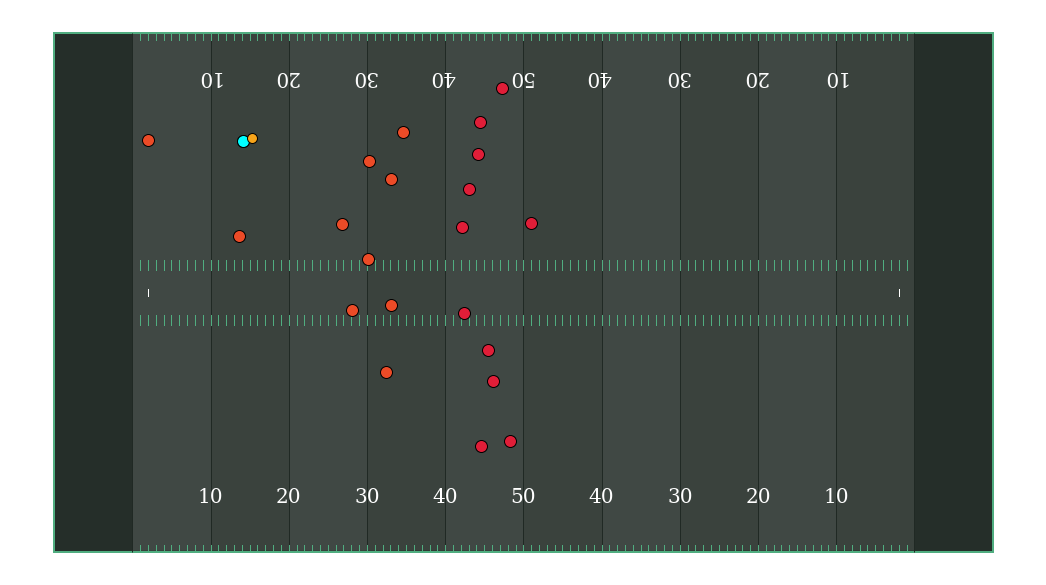

In [ ]:
season = 2019
game_id, play_id = plays(season)
game_id = game_id
play_id = play_id
frame = return_frame(season, game_id, play_id)
home_positions, away_positions, returner_position = playbook_snapshot(season, game_id, play_id, frame)